In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
import os
import sys
import collections
import random
import scipy.signal
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.tsa.arima_model as arima_model
import statsmodels.tsa.vector_ar.var_model as var_model
import nitime.algorithms as alg

sys.path.append('../src/')
import spectral

### Simulated Network

Network from: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3971884/#RSTA20110610M2x27

$x1 \rightarrow x2$:

$x_1(t) = 0.55x_1(t-1) - 0.70x_1(t-2) + \epsilon_1(t)$,

$x_2(t) = 0.56x_2(t-1) - 0.75x_2(t-2) + 0.60x_1(t-1) + \epsilon_2(t)$

where $\sigma_1^2=1.00$ for $\epsilon_1$ and $\sigma_2^2=2.00$ for $\epsilon_2$, both with mean zero

In [2]:
time_extent = (0, .250)
num_trials = 500
sampling_frequency = 200
num_time_points = ((time_extent[1] - time_extent[0]) * sampling_frequency) + 1
time = np.linspace(time_extent[0], time_extent[1], num=num_time_points, endpoint=True)
signal_shape = (len(time), num_trials)


def simulate_arma_model(ar_coefficients, ma_coefficients=None,
                        signal_shape=(100,1), sigma=1, axis=0, num_burnin_samples=10):
    ar = np.r_[1, -ar_coefficients] # add zero-lag and negate
    if ma_coefficients is None:
        ma = np.asarray([1])
    else:
        ma = np.r_[1, ma_coefficients] # add zero-lag
    
    # Add burnin samples to shape
    signal_shape = list(signal_shape)
    signal_shape[axis] += num_burnin_samples
    
    # Get arma process
    white_noise = np.random.normal(0, sigma, size=signal_shape)
    signal = scipy.signal.lfilter(ma, ar, white_noise, axis=axis)
    
    # Return non-burnin samples
    slc = [slice(None)] * len(signal_shape)
    slc[axis] = slice(num_burnin_samples, signal_shape[axis], 1)
    return signal[slc]

ar1 = np.array([.55, -0.70])
x1 = simulate_arma_model(ar1, signal_shape=signal_shape, sigma=1, num_burnin_samples=sampling_frequency)
arima_model.ARMA(x1[:, 0], (2,0)).fit(trend='nc', disp=0).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   51
Model:                     ARMA(2, 0)   Log Likelihood                 -76.942
Method:                       css-mle   S.D. of innovations              1.074
Date:                Wed, 30 Nov 2016   AIC                            159.883
Time:                        23:20:53   BIC                            165.679
Sample:                             0   HQIC                           162.098
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1.y        0.5484      0.092      5.980      0.000         0.369     0.728
ar.L2.y       -0.7596      0.088     -8.638      0.000        -0.932    -0.587
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.3610           -1.0891j            1.1474           -0.1991
AR.2            0.3610           +1.0891j            1.1474            0.1991
-----------------------------------------------------------------------------
"""

In [3]:
ar2 = np.array([.56, -0.75])
x2 = simulate_arma_model(ar2, signal_shape=signal_shape, sigma=2, num_burnin_samples=sampling_frequency)
arima_model.ARMA(x2[:, 0], (2,0)).fit(trend='nc', disp=0).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   51
Model:                     ARMA(2, 0)   Log Likelihood                 -99.641
Method:                       css-mle   S.D. of innovations              1.685
Date:                Wed, 30 Nov 2016   AIC                            205.282
Time:                        23:20:54   BIC                            211.077
Sample:                             0   HQIC                           207.496
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1.y        0.4265      0.103      4.150      0.000         0.225     0.628
ar.L2.y       -0.6899      0.098     -7.015      0.000        -0.883    -0.497
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.3091           -1.1636j            1.2040           -0.2087
AR.2            0.3091           +1.1636j            1.2040            0.2087
-----------------------------------------------------------------------------
"""

In [4]:
x2[1:, :] = 0.60 * x1[:-1, :]

#### x1 and x2 have spectral peaks at 40 Hz

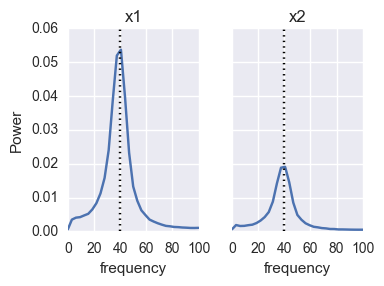

In [5]:
psd1 = spectral.multitaper_power_spectral_density(x1,
                                                  sampling_frequency=sampling_frequency,
                                                  time_halfbandwidth_product=1,
                                                  desired_frequencies=[0, 100])

psd2 = spectral.multitaper_power_spectral_density(x2,
                                                  sampling_frequency=sampling_frequency,
                                                  time_halfbandwidth_product=1,
                                                  desired_frequencies=[0, 100])

fig, axes = plt.subplots(1,2, figsize=(4,3), sharex=True, sharey=True)
psd1.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Power')
axes[0].set_title('x1')
axes[0].axvline(40, color='black', linestyle=':')
psd2.plot(ax=axes[1], legend=False)
axes[1].axvline(40, color='black', linestyle=':')
axes[1].set_title('x2')
plt.tight_layout()

## Spectral Granger Causality

Steps:
1. Make LFPs zero mean (possibly also divide by standard deviation as in Gregoriou et al. 2009)
2. For each trial, estimate the multivariate autoregressive model:
$$ \Sigma_{k=0}^{m} A_k X_{t-k} = E_t $$
where $m$ is the order of the model, $A_k$ is the coefficient matrix and $E_t$ is the residual error with covariance matrix $\Sigma$
3. Average covariance matrix $\Sigma$ of the noise term $E_t$ of the multivariate autoregressive model over trials
4. Average estimated coefficients $A_k$ of the multivariate autoregressive model over trials
5. Calculate transfer function $H$ from the estimated coefficients of the multivariate autoregressive model
$$ H(f) = \left(\Sigma_{k=0}^{m} A_k e^{-2\pi ikf} \right)^{-1}
$$
6. Calculate the spectral matrix $S$ from the transfer function and the covariance matrix
$$ S(f) = H(f)\Sigma H(f)^*
$$
7. Compute the spectral granger using the covariance matrix, transfer function, and spectral matrix:
$$ I_{1 \rightarrow 2} = 
-ln\left\{1 -
\frac{\left(\Sigma_{11} - \frac{\Sigma_{12}^2}{\Sigma_{22}}\right)
\left|H_{21}\right|^2}
{S_{22}(f)}\right\}
$$

$$ I_{2 \rightarrow 1} = 
-ln\left\{1 -
\frac{\left(\Sigma_{22} - \frac{\Sigma_{12}^2}{\Sigma_{11}}\right)
\left|H_{12}\right|^2}
{S_{11}(f)}\right\}
$$



In [6]:
# Step 1
centered_x1 = spectral._center_data(x1)
centered_x2 = spectral._center_data(x2)

x = np.concatenate((centered_x1[..., np.newaxis],
                    centered_x2[..., np.newaxis]),
                   axis=-1)

num_lfps = x.shape[-1]

In [15]:
# Step 2
order = 3
fit = [alg.MAR_est_LWR(x[:, trial, :].T, order)
       for trial in np.arange(x1.shape[1])]

# A shape: order-1 x num_lfps x num_lfps
# cov shape: num_lfps x num_lfps

# Step 3
Sigma = np.mean([trial_fit[1] for trial_fit in fit], axis=0)

# Step 4
A = np.mean([trial_fit[0] for trial_fit in fit], axis=0)

In [16]:
# Step 5
pad = 0
number_of_time_samples = int(num_time_points)
next_exponent = spectral._nextpower2(number_of_time_samples)
number_of_fft_samples = max(
    2 ** (next_exponent + pad), number_of_time_samples)
half_of_fft_samples = number_of_fft_samples//2 - 1

A_0 = np.concatenate((np.eye(num_lfps)[np.newaxis, :, :], A)).reshape((order, -1))
B = np.zeros((A_0.shape[-1], half_of_fft_samples), dtype='complex')
for coef_ind in np.arange(A_0.shape[-1]):
    normalized_freq, B[coef_ind, :] = scipy.signal.freqz(A_0[:, coef_ind],
                                                         worN=half_of_fft_samples)
B = B.reshape((num_lfps, num_lfps, half_of_fft_samples))
H = np.zeros_like(B)
for freq_ind in np.arange(half_of_fft_samples):
    H[:, :, freq_ind] = np.linalg.inv(B[:, :, freq_ind])
freq = (normalized_freq * sampling_frequency) / (2 * np.pi)

In [17]:
# Step 6
S = np.zeros_like(H)
for freq_ind in np.arange(H.shape[-1]):
    S[:, :, freq_ind] = np.linalg.multi_dot(
        [H[:, :, freq_ind],
         Sigma,
         H[:, :, freq_ind].conj().transpose()])
S = np.abs(S)

In [18]:
I12 = -np.log(1 - ((Sigma[0, 0] - Sigma[0, 1]**2 / Sigma[1, 1]) * np.abs(H[1, 0])**2) / S[1, 1])

In [19]:
I21 = -np.log(1 - ((Sigma[1, 1] - Sigma[0, 1]**2 / Sigma[0, 0]) * np.abs(H[0, 1])**2) / S[0, 0])

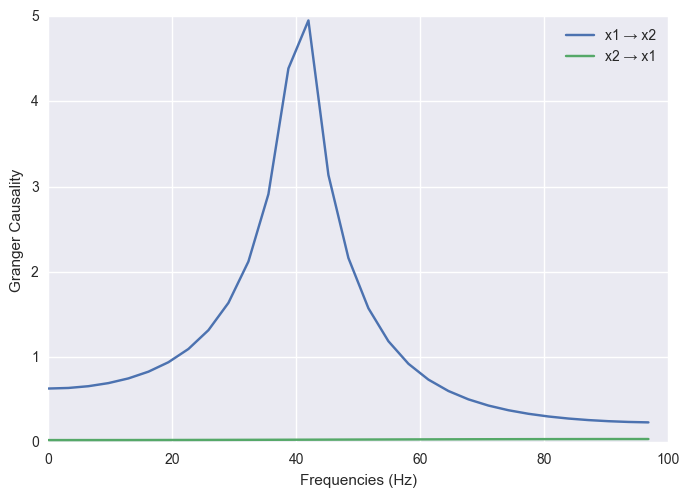

In [20]:
plt.plot(freq, I12, label='x1 → x2')
plt.plot(freq, I21, label='x2 → x1')
plt.xlabel('Frequencies (Hz)')
plt.ylabel('Granger Causality')
plt.legend();

In [13]:
order = 3
fit = [alg.MAR_est_LWR(x[:, trial, :].T, order)
       for trial in np.arange(x1.shape[1])]
Sigma = np.mean([trial_fit[1] for trial_fit in fit], axis=0)
A = np.mean([trial_fit[0] for trial_fit in fit], axis=0)
normalized_freq, f_x2y, f_y2x, f_xy, Sw = alg.granger_causality_xy(A, Sigma, n_freqs=number_of_fft_samples)
freq = (normalized_freq * sampling_frequency) / (2 * np.pi)

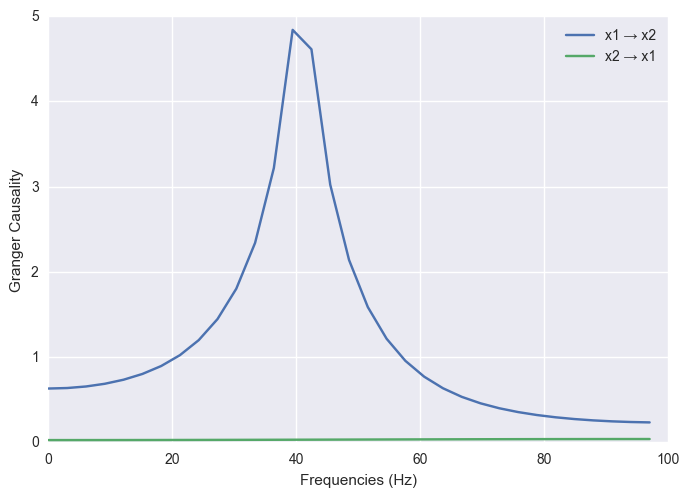

In [14]:
plt.plot(freq, f_x2y, label='x1 → x2')
plt.plot(freq, f_y2x, label='x2 → x1')
plt.xlabel('Frequencies (Hz)')
plt.ylabel('Granger Causality')
plt.legend();